# Part one: The semantic web and a RDFLib example

## Introduction

Work in progress...

The goal is to write down and store scientific experimental data with metadata in a machine readable intelligent form. Integrated in researchers daily workflow the following shall facilitate:
* Re-use of the data (also foreign data)
* Reproducibility
* Building joint databases capable of querying for specific questions like: "I need a material with bandgap in the range 2.4 - 3 eV solvable in ethanol" or "All spectral data on P3HT mixed with whatever".
* Easy publishing with tomorrow's citation and publishing methods

# Learn python for scientific usage
The following tutorials are suited for beginners but might be interesting too for more advanced Pythonians.

* [Python for Scientists](http://www.mpia.de/~robitaille/PY4SCI_SS_2015/)
* [IPython Notebook Tutorial](https://youtu.be/lmoNmY-cmSI?list=PLRJx8WOUx5Xd3_dgw5xRmABUd8MWdsA_C)

## Learn about the semantic web:

A video for the general concept: https://www.youtube.com/watch?v=4x_xzT5eF5Q

Popular Open Data datasets: http://wiki.dbpedia.org/about

Some basics: http://linkeddatabook.com


&nbsp;

&nbsp;

![LOD_Cloud_2014](https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/LOD_Cloud_2014.svg/1280px-LOD_Cloud_2014.svg.png) lod-cloud.net

&nbsp;

&nbsp;

### RDF
The Resource Description Framework (RDF) is a directed, labeled graph **data model** for representing information in the Web (files can be serialized in multiple formats: JSON-LD, Turtle, N3, RDF/XML). "RDF has features that facilitate data merging even if the underlying schemata differ, and it specifically supports the evolution of schemata over time without requiring all the data consumers to be changed" (https://www.w3.org/2001/sw/wiki/RDF).

### Learn querying a RDF database (SPARQL query language)
Here is a good intro video (querying in python is still done via the SPARQL syntax):
* https://www.youtube.com/watch?v=FvGndkpa4K0

Then as a reference there is the W3C Recommendation which defines the syntax and semantics of the SPARQL query language for RDF:

* https://www.w3.org/TR/sparql11-query/

## RDFLib example: Linking experiment data and meta-data as graph
### Import of .txt into pandas

In [1]:
import numpy as np
import pandas as pd
import os
import glob


import matplotlib.pyplot as plt
%matplotlib inline

glob.glob("*.txt")

['high_intens.txt']

In [2]:
# Import spectrum
rawData = pd.read_table("high_intens.txt", names = ["Wavelength [nm]","Counts [1/80 ms]"],
                        header=17, decimal=",")
rawData.head()

,Wavelength [nm],Counts [1/80 ms]
0,181.49,14.00
1,181.71,10.90
2,181.92,17.23
3,182.14,9.45
4,182.36,10.65


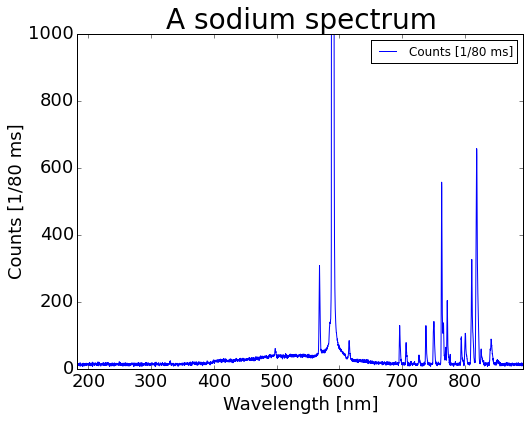

In [3]:
rawData.plot(x="Wavelength [nm]",y="Counts [1/80 ms]",figsize=(8,6),fontsize=18)
plt.title("A sodium spectrum", fontsize=28)
plt.xlabel("Wavelength [nm]",fontsize=18)
plt.ylabel("Counts [1/80 ms]",fontsize=18)
plt.ylim(0,1000)
# plt.savefig("Sectrum.eps")
plt.show()

## Go semantic!
### Namespace
Which ontologies/schemata?
-> dbpedia.org identifiers (URIs)?: http://linkeddatabook.com/editions/1.0/#htoc39

#### Vocabularies for laboratory reporting:
* http://www.sparontologies.net/ontologies
* http://aber-owl.net/ontology/BRIDG
* http://aber-owl.net/ontology/SP
* https://www.w3.org/TR/annotation-model/
* http://xml.coverpages.org/matML.html
* https://rd-alliance.github.io/metadata-directory/standards/rdf-data-cube-vocabulary.html

### Data and metadata to RDF-tripples
We store data values in so-called Literals and use URIs to name and describe the data.

In [4]:
#import rdflib
from rdflib import Graph, ConjunctiveGraph, Literal, BNode, Namespace, URIRef, XSD
from rdflib.namespace import DC, FOAF, RDF, RDFS
from rdflib.plugins.memory import IOMemory

from urllib.parse import quote

### Namespaces define the recources and vocabulary we work with

In [5]:
n = Namespace("http://example.org/people/")

dcterms = Namespace("http://purl.org/dc/terms/")
dcmi = Namespace("http://purl.org/dc/dcmitype/")
dbr = Namespace("http://dbpedia.org/resource/")
owl = Namespace("http://www.w3.org/2002/07/owl#")
wot = Namespace("http://xmlns.com/wot/0.1/")
crypto = Namespace("https://www.w3.org/2000/10/swap/crypto#")

## Think about data and meta-data:
### Experiment

* The data itself with descriptions for its values
* Date experiment, date of last evaluation
* Temperature, pressure, material etc.
* Methods



### Experimentalist
* Name experimentalist
* Mail experimentalist
* Digital signature experimentalist
* Institution of the experimentalist

### Intended publicity
* Private/workgroup/institution/openAccess
* Licensing terms

### Tags
Only very specific tags are useful!

### A rating?
http://vocab.org/review/

In [6]:
cwd = "/home/pathToCwd/"# os.getcwd() get currend working directory
fn = os.path.join(cwd, "methaGraph.jsonld")

mdg = Namespace("file://" + quote(fn) + "#")  # This is the namespace for the experiment

myExp = URIRef("file://" + quote(fn)) # This is the identifier for the experiment
myExp

rdflib.term.URIRef('file:///home/pathToCwd/methaGraph.jsonld')

In [7]:
dataFn = os.path.join(cwd, "high_intens.txt")
data = URIRef(quote(dataFn))
data

rdflib.term.URIRef('/home/pathToCwd/high_intens.txt')

In [8]:
importCode = Literal("""
import pandas as pd

rawData = pd.read_table("high_intens.txt", names = ["Wavelength [nm]","Counts [1/80 ms]"],
header=17, decimal=",")
""" )

# https://www.hl7.org/fhir/datatypes.html#code ?

In [9]:
index = Literal(rawData.index)

In [10]:
header = Literal(str(rawData.columns.values))
header

rdflib.term.Literal("['Wavelength [nm]' 'Counts [1/80 ms]']")

In [11]:
from datetime import date, datetime

dateExp = Literal(date(2013,2,18))
dateLastEval = Literal(datetime.now())

temp = Literal(25.5)
pressure = Literal(1.003)
lamp = URIRef("http://dbpedia.org/resource/Sodium-vapor_lamp")


spectrometer = dbr.Spectrometer
specType =  URIRef("http://oceanoptics.com/product/usb4000-custom")

# Create an identifier to use as the subject for the experimentator.
donna = URIRef(mdg.Donna)

# Create Literal for public key (See below how to create the key itself)
donna_public_keys = Literal('-----BEGIN PGP PUBLIC KEY BLOCK-----\nVersion: GnuPG v1\n\nmQENBFh2cIgBCACcig8bNvxeNTI8HYY9hWU4Ut6NpSpwYnUPzZVWS9UTHKheiz+A\nCBolg0Vr/4tnNzb+zcL9/jm2ZgFwMhOt8K5CQTifYXam8gLlvPfZvhi32lLdTW/x\nmrW/CDQz1N1teJYqQXGcn3kJrWNZ2HGRyjqCfzeRNvOuARqjMNHYBnrioHLw8UA/\nvB0mvmmWfY/zst75SlEF1z5ZZyrnNGvTLGTNXO43RLRNsXVkCjCB/689sGW9kWu5\nafVvvOIaLWQYXLJDlnY5tcfRtwM/Y8izSwWMfRE90lH9biSewU1CaLQf9smyQisW\nSIp2stHaxWPymf+f/KfSMp6Tyj1QyQs9x82HABEBAAG0NERvbm5hIEZhbGVzIChB\nIHRlc3QgdXNlcikgPG1haWx0bzpkb25uYUBleGFtcGxlLm9yZz6JATgEEwECACIF\nAlh2cIgCGy8GCwkIBwMCBhUIAgkKCwQWAgMBAh4BAheAAAoJEJdZONqMEJiHcUcH\n/28H4cKsHYbM1gkrwwbRRfWzot7LoIbsbLBwpQyjtrCcX9P7R63gzH2fsY782qnf\n4WDp2/mRJX7yNa5FbTyicf+l8I+ziPSKGX9u/ag5JqFHlM8bN2/NHvXJG/zh5WOg\nB4G1HqoHx88BdIZF7Dx7cCDIe2S9RdlFTMsh08hwnpaC7xyK5rRSK8KlrNQMF2jc\nmnPUvByEaOkgHlBG4vipNzeIvnY32SOkAtcwVrm6+Jq4bMBM5kg9TQpU7Db/QeAE\nEDTC7Z458oTTW5Ttt41YpW5Q8GNj8vkfmJBR0Eg3UOd+/OcJMg8TIXdgyS7f7Ehq\n1piBeLsZgY4zoxXcVOMbFsI=\n=lA5q\n-----END PGP PUBLIC KEY BLOCK-----\n')

publicity = Literal("Workgroup")

tag1 = Literal("SPAM SPAM SPAM EGG")

### Make list of triples

In [12]:
experiment = [(myExp, RDF.type, dbr.Experiment),
              (myExp, RDFS.label, Literal("myExperimentGraph")),
              (myExp, dcterms.date, dateExp),
              (myExp, dcterms.modifed, dateLastEval ),
              (myExp, dcmi.Dataset, data),
              (data, RDFS.label, header),
              (myExp, dcterms.accrualMethod, spectrometer),
              (spectrometer, RDF.type, specType),
              (myExp, dbr.Light,lamp),
             ]

experimentator = [(donna, RDF.type, FOAF.Person),
                  (donna, FOAF.name, Literal("Donna Fales")),
                  (donna, FOAF.mbox, URIRef("mailto:donna@example.org")),
                  (donna, dcterms.creator, myExp),
                  (donna, wot.hasKey, donna_public_keys)
                 ]

public = [(myExp, dcterms.accessRights, publicity)]

## Create graph with RDFLib

In [13]:
# A Conjunctive graph is an (unnamed) aggregation of all the named graphs within a Store.
# See https://github.com/RDFLib/rdflib/blob/master/examples/conjunctive_graphs.py

g = ConjunctiveGraph()
if os.path.exists(fn):
    g.load(myExp, format="json-ld")
    g.bind("dc", DC)
    g.bind("foaf", FOAF)
    g.bind("dcterms", dcterms)
    g.bind("dcmi", dcmi)
    g.bind("dbr", dbr)
    g.bind("owl", owl)
    g.bind("wot", wot)
    g.bind("dcterms", dcterms)
    g.bind("mdg", mdg)
    g.bind("crypto", crypto)

In [14]:
# Add triples to named graphs
gExp = Graph(store=g.store, identifier="Experiment")
gExpTator = Graph(store=g.store, identifier="Experimentator")
gPub = Graph(store=g.store, identifier="Publicity")

for triple in experiment:
    gExp.add(triple)
    
for triple in experimentator:
    gExpTator.add(triple)
    
for triple in public:
    gPub.add(triple)


# Create context for adressing the whole experiment data and metadata
gExpGraph = Graph(store=g.store, identifier="myExperimentGraph")

gExpGraph += gExp + gExpTator + gPub

pd.DataFrame(list(g.triples((None, None, None))), columns=["Subjects", "Predicates", "Objects"])

,Subjects,Predicates,Objects
0,file:///home/pathToCwd/methaGraph.jsonld,http://purl.org/dc/terms/accrualMethod,http://dbpedia.org/resource/Spectrometer
1,http://dbpedia.org/resource/Spectrometer,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://oceanoptics.com/product/usb4000-custom
2,file:///home/pathToCwd/methaGraph.jsonld,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbpedia.org/resource/Experiment
3,file:///home/pathToCwd/methaGraph.jsonld#Donna,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://xmlns.com/foaf/0.1/Person
4,file:///home/pathToCwd/methaGraph.jsonld#Donna,http://purl.org/dc/terms/creator,file:///home/pathToCwd/methaGraph.jsonld
5,file:///home/pathToCwd/methaGraph.jsonld,http://purl.org/dc/terms/accessRights,Workgroup
6,/home/pathToCwd/high_intens.txt,http://www.w3.org/2000/01/rdf-schema#label,['Wavelength [nm]' 'Counts [1/80 ms]']
7,file:///home/pathToCwd/methaGraph.jsonld,http://purl.org/dc/dcmitype/Dataset,/home/pathToCwd/high_intens.txt
8,file:///home/pathToCwd/methaGraph.jsonld,http://purl.org/dc/terms/modifed,2017-01-16T21:26:03.401966
9,file:///home/pathToCwd/methaGraph.jsonld#Donna,http://xmlns.com/wot/0.1/hasKey,-----BEGIN PGP PUBLIC KEY BLOCK-----\nVersion:...


## Visualize graph

In [18]:
import matplotlib.pyplot as plt
import networkx as nx

def drwGraph(g, color):
    G = nx.Graph()

    # In NetworkX subjects and objects are nodes and predicates are edges
    for s, p, o in g:
        # Compaction
        su = s.split("/")[-1].split("#")[-1]
        pr = p.split("/")[-1].split("#")[-1]
        ob = o.split("/")[-1].split("#")[-1]

        G.add_edge(su, ob, {pr: "" })


    plt.figure(figsize=(14,10))
    node_sizes = [200*len(G.edges(n)) for n in G.nodes()] # Bigger for more edges
    pos = nx.spring_layout(G)

    nx.draw_networkx(G, pos=pos, node_size=node_sizes, linewidths=0, node_color=color)
    nx.draw_networkx_edge_labels(G,pos)
    plt.box("off")
    plt.axis("off")
    plt.show()

/home/m/Schreibtisch/Interactive Labbook/MathVenv/lib/python3.4/site-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/m/Schreibtisch/Interactive Labbook/MathVenv/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


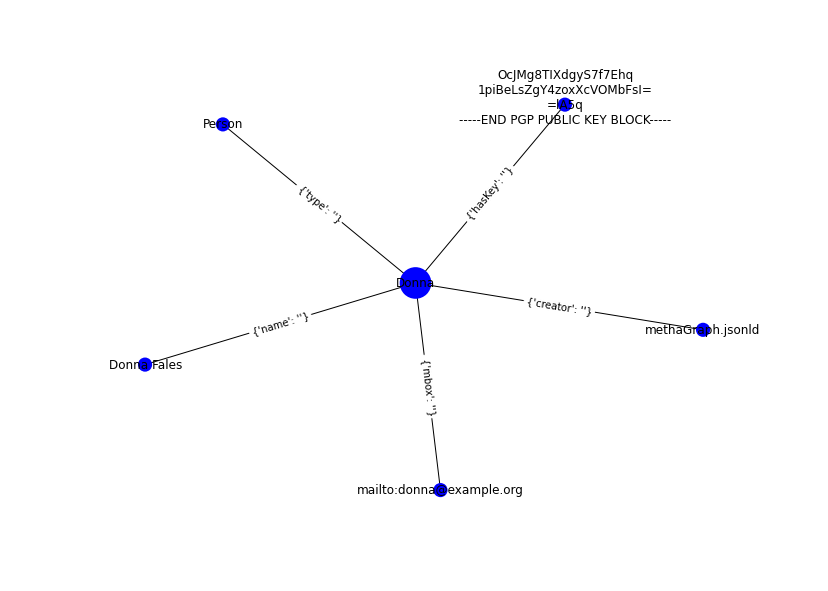

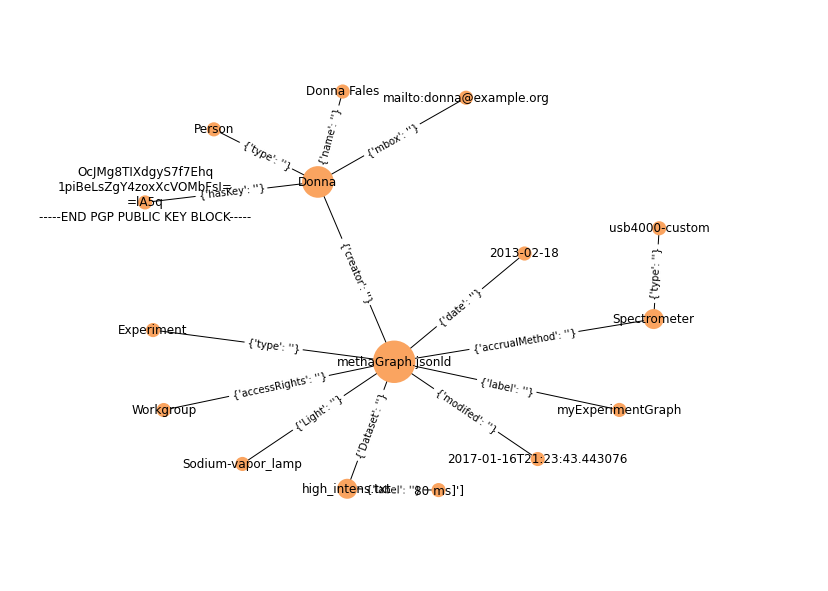

In [20]:
drwGraph(gExpTator, "b")
drwGraph(gExpGraph, "sandybrown")

## Sign graph and store it
* Digital signature experimentator
    * If you are not at all fammiliar with assymetric key cryptography: https://www.youtube.com/watch?v=CR8ZFRVmQLg
    * https://pythonhosted.org/python-gnupg/
    * https://www.w3.org/2005/Incubator/webid/wiki/Main_Page ?
    * https://github.com/detrout/python-webid
    
### Create GPG keys

In [15]:
import gnupg
gpg = gnupg.GPG()

# Create a key pair
input_data = gpg.gen_key_input(key_type="RSA", key_length=2048, name_real="Donna Fales"
                              ,name_comment="A test user", name_email="mailto:donna@example.org")

# only once:
# key = gpg.gen_key(input_data) # See https://pythonhosted.org/python-gnupg/#performance-issues

In [16]:
# List public keys
keyData = gpg.list_keys() # private keys: gpg.list_keys(True)

output = """
[{'algo': '1',
  'date': '1484157064',
  'dummy': '',
  'expires': '',
  'fingerprint': '92B19ACC9C85FA69DF81A5C4975938DA8C109887',
  'keyid': '975938DA8C109887',
  'length': '2048',
  'ownertrust': 'u',
  'sig': '',
  'sigs': [],
  'subkeys': [],
  'trust': 'u',
  'type': 'pub',
  'uids': ['Donna Fales (A test user) <mailto:donna@example.org>']}]
  """

# The list should contain something like this (depending on your existing keys)
print(output)


[{'algo': '1',
  'date': '1484157064',
  'dummy': '',
  'expires': '',
  'fingerprint': '92B19ACC9C85FA69DF81A5C4975938DA8C109887',
  'keyid': '975938DA8C109887',
  'length': '2048',
  'ownertrust': 'u',
  'sig': '',
  'sigs': [],
  'subkeys': [],
  'trust': 'u',
  'type': 'pub',
  'uids': ['Donna Fales (A test user) <mailto:donna@example.org>']}]
  


In [17]:
# Export key
keyid = '975938DA8C109887'

ascii_donna_public_keys = gpg.export_keys(keyid)
donna_public_keys = Literal(ascii_donna_public_keys)

print(ascii_donna_public_keys)

-----BEGIN PGP PUBLIC KEY BLOCK-----
Version: GnuPG v1

mQENBFh2cIgBCACcig8bNvxeNTI8HYY9hWU4Ut6NpSpwYnUPzZVWS9UTHKheiz+A
CBolg0Vr/4tnNzb+zcL9/jm2ZgFwMhOt8K5CQTifYXam8gLlvPfZvhi32lLdTW/x
mrW/CDQz1N1teJYqQXGcn3kJrWNZ2HGRyjqCfzeRNvOuARqjMNHYBnrioHLw8UA/
vB0mvmmWfY/zst75SlEF1z5ZZyrnNGvTLGTNXO43RLRNsXVkCjCB/689sGW9kWu5
afVvvOIaLWQYXLJDlnY5tcfRtwM/Y8izSwWMfRE90lH9biSewU1CaLQf9smyQisW
SIp2stHaxWPymf+f/KfSMp6Tyj1QyQs9x82HABEBAAG0NERvbm5hIEZhbGVzIChB
IHRlc3QgdXNlcikgPG1haWx0bzpkb25uYUBleGFtcGxlLm9yZz6JATgEEwECACIF
Alh2cIgCGy8GCwkIBwMCBhUIAgkKCwQWAgMBAh4BAheAAAoJEJdZONqMEJiHcUcH
/28H4cKsHYbM1gkrwwbRRfWzot7LoIbsbLBwpQyjtrCcX9P7R63gzH2fsY782qnf
4WDp2/mRJX7yNa5FbTyicf+l8I+ziPSKGX9u/ag5JqFHlM8bN2/NHvXJG/zh5WOg
B4G1HqoHx88BdIZF7Dx7cCDIe2S9RdlFTMsh08hwnpaC7xyK5rRSK8KlrNQMF2jc
mnPUvByEaOkgHlBG4vipNzeIvnY32SOkAtcwVrm6+Jq4bMBM5kg9TQpU7Db/QeAE
EDTC7Z458oTTW5Ttt41YpW5Q8GNj8vkfmJBR0Eg3UOd+/OcJMg8TIXdgyS7f7Ehq
1piBeLsZgY4zoxXcVOMbFsI=
=lA5q
-----END PGP PUBLIC KEY BLOCK-----



### Hash data
http://pythoncentral.io/hashing-files-with-python/

In [18]:
import hashlib
filename = "high_intens.txt"

BLOCKSIZE = 65536
hasher = hashlib.sha1()

with open(filename, "rb") as stream:
    buf = stream.read(BLOCKSIZE)
    while len(buf) > 0:
        hasher.update(buf)
        buf = stream.read(BLOCKSIZE)

dataHash = Literal(hasher.hexdigest())

gExp.add((data,crypto.sha, dataHash))

In [19]:
# You can sign data with gpg directly but we will sign a hash of the
# graph including the hash of the data as a Literal object

with open(filename, "rb") as stream:
    signed_data = gpg.sign_file(stream, keyid="975938DA8C109887")

print(str(signed_data)[0:300] + "\n\n...\n...")

-----BEGIN PGP SIGNED MESSAGE-----
Hash: SHA1

177,54	13,20
177,75	13,20
177,97	13,20
178,19	11,52
178,41	11,72
178,63	13,68
178,85	10,73
179,07	12,98
179,29	15,51
179,51	16,87
179,73	10,66
179,95	12,67
180,17	17,56
180,39	17,04
180,61	12,33
180,83	12,68
181,05	13,23
181,27	11,28
1

...
...


### Hash graph
RDFLib.RGDA1: The RDF Graph Digest Algorithm 1 (RGDA1) produces cryptographically secure hashes for all RDF graphs
    * create platform-independent, cryptographically secure, reproducible identifiers for all RDF graphs, (from: WEBSIG: A DIGITAL SIGNATURE FRAMEWORK FOR THE WEB)

In [20]:
from rdflib.compare import isomorphic, _TripleCanonicalizer
# Warning: the time to canonicalize bnodes may increase exponentially on degenerate larger graphs


# We use the context to specify which part of the graph we want to hash and sign
gHash = str(_TripleCanonicalizer(gExpGraph).to_hash())
gHash

'1000973175714773174394657975727339334874012862822329149053392935196204522504018'

### Sign hash

In [21]:
sH = gpg.sign(gHash, keyid="975938DA8C109887") # gpg object
signedHash = Literal(str(sH))
sigDate = Literal(datetime.now())

print(signedHash)

-----BEGIN PGP SIGNED MESSAGE-----
Hash: SHA1

1000973175714773174394657975727339334874012862822329149053392935196204522504018
-----BEGIN PGP SIGNATURE-----
Version: GnuPG v1

iQEcBAEBAgAGBQJYfTqAAAoJEJdZONqMEJiH0MUH/A5QyhEcp07UDk0KzUwv4h7w
h36sr2NjMTymkfYBDCYXMdYVQRL3GSL0jHbT6J57H7eyVFLqCf7tk5pBDeGNz+d4
WRr850N+UJVx56sX1bkXRlmZm5mhqBXkWlwx95GGzHGsm52Ct7B0kN20dyyJx3I2
xWSNay8gOvtrXs0KWdnpZTkyQP3nVJ+TF3m26UBgDjnxAY+ne1OpipLGwB5DVWZl
LSC2pKMZdq7WapFKJ5WkXW7G9gV9bfFsaY65Q7c5QH7AhgtAXi6HIuqCLNCMgiTk
J8ERS7IqFXLHUdeWty+bZNfaral4VGhYxo24qUxdTQDtmxsd8PXQP0I7WrFGWTY=
=OdGv
-----END PGP SIGNATURE-----



### Add signature to a new named graph "signatures"

In [22]:
sig = Graph(store=g.store, identifier="Signatures")

# Remove old signatures
sig.remove((None, None, None))

sig.add((donna, wot.signed, signedHash))  # the wot.signed is used wrong in this examle
sig.add((myExp, wot.sigdate, sigDate))

pd.DataFrame(list(sig.triples((None, None, None))), columns=["Subjects", "Predicates", "Objects"])

,Subjects,Predicates,Objects
0,file:///home/pathToCwd/methaGraph.jsonld,http://xmlns.com/wot/0.1/sigdate,2017-01-16T21:26:24.740440
1,file:///home/pathToCwd/methaGraph.jsonld#Donna,http://xmlns.com/wot/0.1/signed,-----BEGIN PGP SIGNED MESSAGE-----\nHash: SHA1...


In [23]:
# Print out names/contexts of all graphs
for c in g.contexts():
    print(c)

<Publicity> a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'IOMemory'].
<Experiment> a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'IOMemory'].
<Experimentator> a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'IOMemory'].
<myExperimentGraph> a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'IOMemory'].
<Signatures> a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'IOMemory'].


## Store in json-ld file

In [24]:
import rdflib_jsonld
g.serialize("methaGraph.jsonld", format='json-ld')

## Open Graph again and look into data

In [25]:
newGraph = ConjunctiveGraph()

newGraph.load("methaGraph.jsonld", format='json-ld')

pd.DataFrame(list(newGraph.triples((None, None, None))), columns=["Subjects", "Predicates", "Objects"])

,Subjects,Predicates,Objects
0,file:///home/pathToCwd/methaGraph.jsonld,http://purl.org/dc/terms/accrualMethod,http://dbpedia.org/resource/Spectrometer
1,http://dbpedia.org/resource/Spectrometer,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://oceanoptics.com/product/usb4000-custom
2,file:///home/pathToCwd/methaGraph.jsonld,http://www.w3.org/2000/01/rdf-schema#label,myExperimentGraph
3,file:///home/pathToCwd/methaGraph.jsonld#Donna,http://xmlns.com/foaf/0.1/mbox,mailto:donna@example.org
4,file:///home/pathToCwd/methaGraph.jsonld#Donna,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://xmlns.com/foaf/0.1/Person
5,file:///home/pathToCwd/methaGraph.jsonld,http://purl.org/dc/terms/modifed,2017-01-16T21:26:03.401966
6,file:///home/pathToCwd/methaGraph.jsonld#Donna,http://xmlns.com/wot/0.1/signed,-----BEGIN PGP SIGNED MESSAGE-----\nHash: SHA1...
7,file:///home/pathToCwd/high_intens.txt,http://www.w3.org/2000/01/rdf-schema#label,['Wavelength [nm]' 'Counts [1/80 ms]']
8,file:///home/pathToCwd/methaGraph.jsonld,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://dbpedia.org/resource/Experiment
9,file:///home/pathToCwd/methaGraph.jsonld#Donna,http://xmlns.com/wot/0.1/hasKey,-----BEGIN PGP PUBLIC KEY BLOCK-----\nVersion:...


In [ ]:
# Print out names/contexts of all graphs
for c in newGraph.contexts():
    print(c)

c.identifier

## Verification of a graph


In [26]:
# Quick and dirty
for h in newGraph.objects(donna, wot.signed):
    # First verify the signature
    if gpg.verify(str(h)):
        # Second compare hash
        sigHash = gpg.decrypt(h).data.decode("utf-8").strip() # gpg.decrypt(h): bytes --> string
        
        identifier = str(g.value(myExp, RDFS.label))
        signedG = g.get_context(identifier)
        realHash = str(_TripleCanonicalizer(signedG).to_hash())  # What happens if there are two
                                                                # equal identifiers?
        print(sigHash)
        print(realHash)
        
        if sigHash == realHash:
            print("Graph verified")
        
        else:
            print("Signature verified but graph has changed")
    
    else:
        print("Signature verification failed")

1000973175714773174394657975727339334874012862822329149053392935196204522504018
1000973175714773174394657975727339334874012862822329149053392935196204522504018
Graph verified


In [ ]:
# Is this really a safe verification ?

to_isomorphic(signedG).internal_hash() # The conjunctive graph is hashed instead of the named graph ?? --> ISOMORPHIC
isomorphic(to_isomorphic(signedG) == to_isomorphic(g))

# !!!
_TripleCanonicalizer(signedG).to_hash() == _TripleCanonicalizer(myG).to_hash()

## Store graph with sleepycat

In [10]:
# A Conjunctive graph is an (unnamed) aggregation of all the named graphs within a Store.
# See https://github.com/RDFLib/rdflib/blob/master/examples/conjunctive_graphs.py
from rdflib.store import NO_STORE, VALID_STORE

path = "myRDFLibStore"
store = 'Sleepycat'

gS = ConjunctiveGraph(store=store, identifier="myRDFLibStore")

# We want to store the graph after use on the disk
rt = gS.open(path, create=False)

if rt == NO_STORE:
    # There is no underlying Sleepycat infrastructure, create it
    gS.open(path, create=True)
else:
    assert rt == VALID_STORE, 'The underlying store is corrupt'


# Add tripples
gS += g

# After use close!
gS.close()

## Create class for automated integration in workflow
* https://docs.python.org/3.4/tutorial/classes.html
* https://github.com/RDFLib/rdflib/blob/master/examples/film.py

## Search through ontologies

In [108]:
import ontospy

model = ontospy.Ontospy("https://www.w3.org/2000/10/swap/crypto#")
model.classes

----------
Reading: <https://www.w3.org/2000/10/swap/crypto#>
.. trying rdf serialization: <xml>
..... success!
----------
Loaded 35 triples.
----------
RDF sources loaded successfully: 1 of 1.
----------
-> https://www.w3.org/2000/10/swap/crypto#
Scanning entities...
----------
Ontologies.........: 0
Classes............: 2
Properties.........: 5
..annotation.......: 0
..datatype.........: 0
..object...........: 2
Concepts (SKOS)....: 0
----------


[<Class *http://www.w3.org/2000/10/swap/crypto#HashFunction*>,
 <Class *http://www.w3.org/2000/10/swap/crypto#PublicKeyObject*>]

In [109]:
model.properties

[<Property *http://www.w3.org/2000/10/swap/crypto#md5*>,
 <Property *http://www.w3.org/2000/10/swap/crypto#sha*>,
 <Property *http://www.w3.org/2000/10/swap/crypto#sign*>,
 <Property *http://www.w3.org/2000/10/swap/crypto#verify*>,
 <Property *http://www.w3.org/2000/10/swap/crypto#verifyBoolean*>]

In [110]:
model.printClassTree()

http://www.w3.org/2000/10/swap/crypto#HashFunction
http://www.w3.org/2000/10/swap/crypto#PublicKeyObject
